In [1]:
import torch
import numpy as np
import syft as sy
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset as FederatedDataset
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

unsupported operand type(s) for |: 'type' and 'NoneType'


C:\Users\ek\miniconda3\envs\help\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
url = 'https://raw.githubusercontent.com/samhithanair/Energy-Consumption-Using-LSTM-and-Federated-Learning/main/Household_electricity_dataset.csv'
df = pd.read_csv(url)

In [3]:
df_numeric = df.select_dtypes(include=[np.number])

In [4]:
X = df_numeric.drop(columns=['Value'])
y = df_numeric['Value']

In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
split_idx1 = len(X_scaled) // 3
split_idx2 = 2 * len(X_scaled) // 3

In [7]:
X_c1 = X_scaled[:split_idx1]
X_c2 = X_scaled[split_idx1:split_idx2]
X_c3 = X_scaled[split_idx2:]

In [8]:
y_c1 = y[:split_idx1].values.reshape(-1, 1)
y_c2 = y[split_idx1:split_idx2].values.reshape(-1, 1)
y_c3 = y[split_idx2:].values.reshape(-1, 1)

In [9]:
X_c1_tensor = torch.tensor(X_c1, dtype=torch.float32)
X_c2_tensor = torch.tensor(X_c2, dtype=torch.float32)
X_c3_tensor = torch.tensor(X_c3, dtype=torch.float32)

y_c1_tensor = torch.tensor(y_c1, dtype=torch.float32)
y_c2_tensor = torch.tensor(y_c2, dtype=torch.float32)
y_c3_tensor = torch.tensor(y_c3, dtype=torch.float32)

In [10]:
dataset_c1 = FederatedDataset(X_c1_tensor, y_c1_tensor)
dataset_c2 = FederatedDataset(X_c2_tensor, y_c2_tensor)
dataset_c3 = FederatedDataset(X_c3_tensor, y_c3_tensor)

In [11]:
batch_size = 64

In [12]:
dataloader_c1 = DataLoader(dataset_c1, batch_size=batch_size, shuffle=True)
dataloader_c2 = DataLoader(dataset_c2, batch_size=batch_size, shuffle=True)
dataloader_c3 = DataLoader(dataset_c3, batch_size=batch_size, shuffle=True)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
input_size = X_c1_tensor.shape[1]
hidden_size = 16
output_size = 1
input_size

19

In [15]:
model = LSTMModel(input_size, hidden_size, output_size)
model_c1 = LSTMModel(input_size, hidden_size, output_size)
model_c2 = LSTMModel(input_size, hidden_size, output_size)
model_c3 = LSTMModel(input_size, hidden_size, output_size)

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
import matplotlib.pyplot as plt

def train(model,dataloader):
    epochs = 1000
    loss_values = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data in [dataloader_c1]:
            for inputs, labels in data:
                optimizer.zero_grad()
                outputs = model(inputs.unsqueeze(1))
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss*0.0001}")
        loss_values.append(running_loss*0.0001)
    
    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

Epoch 1, Loss: 0.6458205322265625
Epoch 2, Loss: 0.6433450561523438
Epoch 3, Loss: 0.6454452758789063
Epoch 4, Loss: 0.6479230834960937
Epoch 5, Loss: 0.6471734436035157
Epoch 6, Loss: 0.6412766235351562
Epoch 7, Loss: 0.6464153503417969
Epoch 8, Loss: 0.6427817626953125
Epoch 9, Loss: 0.6386607788085937
Epoch 10, Loss: 0.6459594787597657
Epoch 11, Loss: 0.6442284118652344
Epoch 12, Loss: 0.6419246398925782
Epoch 13, Loss: 0.6455004882812501
Epoch 14, Loss: 0.64511728515625
Epoch 15, Loss: 0.6428836669921876
Epoch 16, Loss: 0.6434348571777344
Epoch 17, Loss: 0.6468628723144532
Epoch 18, Loss: 0.6448946533203125
Epoch 19, Loss: 0.6425708557128906
Epoch 20, Loss: 0.6439898864746094
Epoch 21, Loss: 0.6421095886230469
Epoch 22, Loss: 0.6454405822753907
Epoch 23, Loss: 0.6472090576171875
Epoch 24, Loss: 0.6425932495117188
Epoch 25, Loss: 0.6465523315429688
Epoch 26, Loss: 0.6425073303222657
Epoch 27, Loss: 0.6453437194824219
Epoch 28, Loss: 0.6435015991210937
Epoch 29, Loss: 0.6415320190429

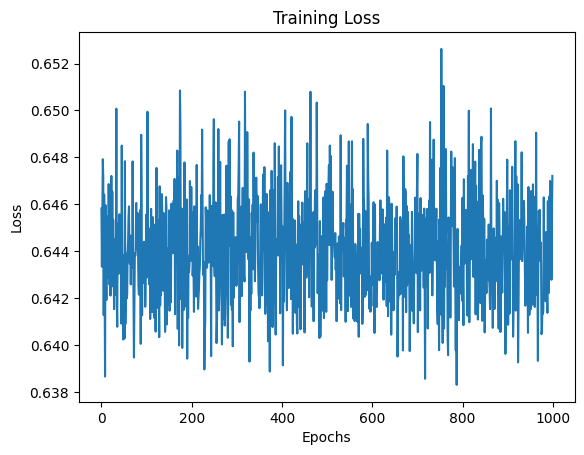

CPU times: total: 38.6 s
Wall time: 35.6 s


In [18]:
%%time
train(model_c1,dataloader_c1)

Epoch 1, Loss: 0.6458320922851563
Epoch 2, Loss: 0.6433060791015626
Epoch 3, Loss: 0.6403943908691406
Epoch 4, Loss: 0.6401645812988281
Epoch 5, Loss: 0.6440817199707032
Epoch 6, Loss: 0.6474024658203126
Epoch 7, Loss: 0.6421181640625
Epoch 8, Loss: 0.6428779968261719
Epoch 9, Loss: 0.645808447265625
Epoch 10, Loss: 0.6471535949707031
Epoch 11, Loss: 0.6401909240722656
Epoch 12, Loss: 0.6453416320800781
Epoch 13, Loss: 0.6420906921386719
Epoch 14, Loss: 0.6430714111328125
Epoch 15, Loss: 0.6484425292968751
Epoch 16, Loss: 0.6431928283691406
Epoch 17, Loss: 0.6426345031738282
Epoch 18, Loss: 0.6440196044921875
Epoch 19, Loss: 0.6423459533691407
Epoch 20, Loss: 0.6449815551757813
Epoch 21, Loss: 0.64535615234375
Epoch 22, Loss: 0.6439144836425782
Epoch 23, Loss: 0.6490646606445313
Epoch 24, Loss: 0.6464714477539063
Epoch 25, Loss: 0.6423140686035157
Epoch 26, Loss: 0.6442874877929687
Epoch 27, Loss: 0.6469662292480469
Epoch 28, Loss: 0.6432121215820312
Epoch 29, Loss: 0.6460271911621094


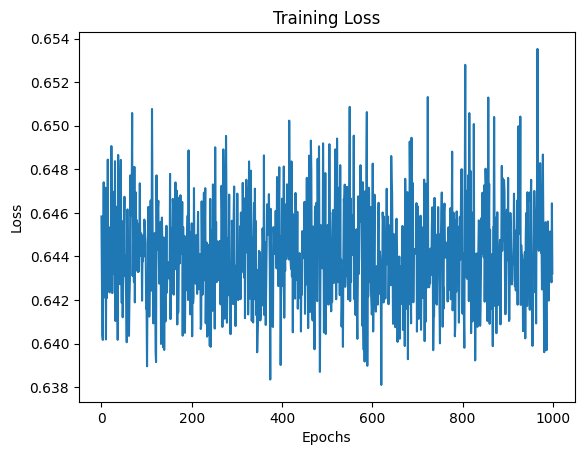

CPU times: total: 29.1 s
Wall time: 28.7 s


In [19]:
%%time
train(model_c2,dataloader_c2)

Epoch 1, Loss: 0.6427046813964844
Epoch 2, Loss: 0.6415827819824219
Epoch 3, Loss: 0.6401991088867188
Epoch 4, Loss: 0.6431691955566406
Epoch 5, Loss: 0.6366295043945313
Epoch 6, Loss: 0.6386539489746094
Epoch 7, Loss: 0.6431437683105469
Epoch 8, Loss: 0.6461546325683594
Epoch 9, Loss: 0.6393600036621094
Epoch 10, Loss: 0.6437282104492188
Epoch 11, Loss: 0.6420723510742188
Epoch 12, Loss: 0.6422465148925781
Epoch 13, Loss: 0.6407579162597656
Epoch 14, Loss: 0.6378603881835938
Epoch 15, Loss: 0.6420303649902344
Epoch 16, Loss: 0.6395711791992188
Epoch 17, Loss: 0.6391844421386719
Epoch 18, Loss: 0.6441583374023437
Epoch 19, Loss: 0.6437096130371094
Epoch 20, Loss: 0.6423980529785157
Epoch 21, Loss: 0.6416124816894532
Epoch 22, Loss: 0.6411103759765625
Epoch 23, Loss: 0.6384430297851563
Epoch 24, Loss: 0.6445519714355469
Epoch 25, Loss: 0.6415827453613282
Epoch 26, Loss: 0.6438943298339844
Epoch 27, Loss: 0.6449330017089844
Epoch 28, Loss: 0.6468124084472656
Epoch 29, Loss: 0.64201047973

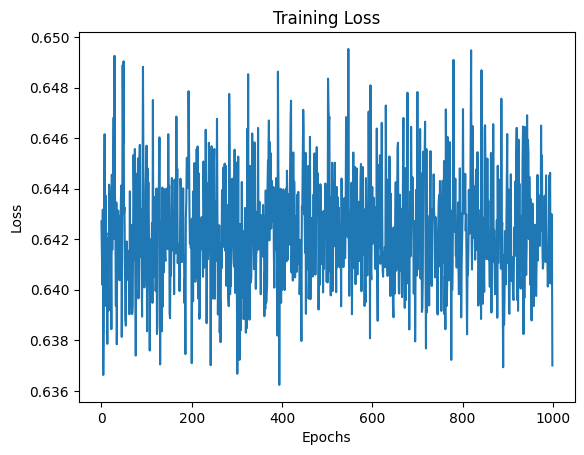

CPU times: total: 29.7 s
Wall time: 28.8 s


In [20]:
%%time
train(model_c3,dataloader_c3)

In [21]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.unsqueeze(1))
            predictions.append(outputs.detach().numpy())
    return np.vstack(predictions)

In [22]:
predictions_c1 = predict(model_c1, dataloader_c1)
predictions_c2 = predict(model_c2, dataloader_c2)
predictions_c3 = predict(model_c3, dataloader_c3)

In [42]:
global_avg_prediction = float((predictions_c1.mean(axis=0) + predictions_c2.mean(axis=0) + predictions_c3.mean(axis=0)) / 3)

In [23]:
print("Predictions for dataset_c1:", predictions_c1[-1])
print("Predictions for dataset_c2:", predictions_c2[-1])
print("Predictions for dataset_c3:", predictions_c3[-1])

Predictions for dataset_c1: [-0.2225086]
Predictions for dataset_c2: [-0.24136911]
Predictions for dataset_c3: [-0.18549693]


In [24]:
df_numeric_scaled = scaler.fit_transform(df_numeric)
y = df_numeric_scaled[:, -1]

yc1 = y[:split_idx1]
yc2 = y[split_idx1:split_idx2]
yc3 = y[split_idx2:]

In [25]:
predictions_c1_numpy = np.array(predictions_c1)
predictions_c2_numpy = np.array(predictions_c2)
predictions_c3_numpy = np.array(predictions_c3)

In [26]:
mse_c1 = mean_squared_error(predictions_c1_numpy, yc1)
mse_c2 = mean_squared_error(predictions_c2_numpy, yc2)
mse_c3 = mean_squared_error(predictions_c3_numpy, yc3)
print("Mean Squared Error of Client 1:", mse_c1)
print("Mean Squared Error of Client 2:", mse_c2)
print("Mean Squared Error of Client 3:", mse_c3)

Mean Squared Error of Client 1: 0.18091327252812903
Mean Squared Error of Client 2: 0.5668009877015411
Mean Squared Error of Client 3: 1.0549638746378385


In [27]:
model_state_dict_c1 = model_c1.state_dict()
model_state_dict_c2 = model_c2.state_dict()
model_state_dict_c3 = model_c3.state_dict()

In [28]:
tensor_c1 = list(model_state_dict_c1.values())[0]
tensor_c2 = list(model_state_dict_c2.values())[0]
tensor_c3 = list(model_state_dict_c3.values())[0]

In [29]:
array_2d = np.empty((0, tensor_c3.size(1)))

for row in tensor_c3:
    row_array = row.numpy().reshape(1, -1)
    array_2d = np.vstack((array_2d, row_array))
for row in tensor_c2:
    row_array = row.numpy().reshape(1, -1)
    array_2d = np.vstack((array_2d, row_array))
for row in tensor_c1:
    row_array = row.numpy().reshape(1, -1)
    array_2d = np.vstack((array_2d, row_array))

In [30]:
tensor_2d = torch.tensor(array_2d, dtype=torch.float32)
input_size = tensor_2d.shape[1]
input_size

19

In [31]:
tensor_dataset = FederatedDataset(tensor_2d)

In [32]:
model_weights_dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

Epoch 1, Loss: 0.6386295349121094
Epoch 2, Loss: 0.636080126953125
Epoch 3, Loss: 0.6296734802246094
Epoch 4, Loss: 0.6305653808593751
Epoch 5, Loss: 0.6243446899414062
Epoch 6, Loss: 0.6212340637207031
Epoch 7, Loss: 0.6111813354492188
Epoch 8, Loss: 0.6092372009277344
Epoch 9, Loss: 0.6003126037597657
Epoch 10, Loss: 0.5923341979980469
Epoch 11, Loss: 0.5890202087402344
Epoch 12, Loss: 0.5828981689453125
Epoch 13, Loss: 0.5799489440917969
Epoch 14, Loss: 0.5683240234375
Epoch 15, Loss: 0.5642623779296875
Epoch 16, Loss: 0.5510253112792969
Epoch 17, Loss: 0.5463072753906251
Epoch 18, Loss: 0.5365047637939453
Epoch 19, Loss: 0.5338180236816407
Epoch 20, Loss: 0.5239072265625
Epoch 21, Loss: 0.5190509155273437
Epoch 22, Loss: 0.5069673461914063
Epoch 23, Loss: 0.5044280090332032
Epoch 24, Loss: 0.49392641601562504
Epoch 25, Loss: 0.48716363830566406
Epoch 26, Loss: 0.4847007873535156
Epoch 27, Loss: 0.4811011505126953
Epoch 28, Loss: 0.4723927673339844
Epoch 29, Loss: 0.4679668518066406

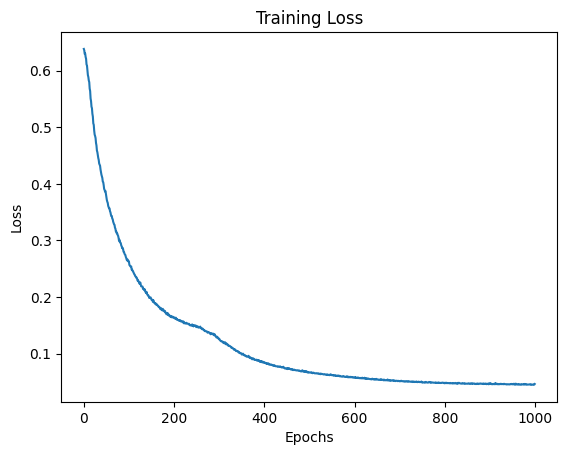

In [33]:
train(model,model_weights_dataloader)

In [46]:
def global_predict(model, dataloader):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]
            batch_size = inputs.size(0)
            h0 = torch.zeros(1, batch_size, model.hidden_size).to(inputs.device)
            c0 = torch.zeros(1, batch_size, model.hidden_size).to(inputs.device)
            output = model(inputs.unsqueeze(1), (h0, c0))  # Adjust input shape
            predictions.append(output)
    return predictions

In [44]:
global_avg_predictions = predict(model,model_weights_dataloader)

In [45]:
global_avg_prediction

-0.22794075310230255